## Frequency analysis with MNE

Lab Rotation of Charlotte Brandebusemeyer
start date: 26th May - 1st June 2021

In [1]:
# to read in xdf files
import pyxdf

In [2]:
import itertools

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
#%matplotlib notebook
from scipy.stats import ttest_rel

# mne and neurodsp have to be imported manually via pip install 
import mne
from mne.time_frequency import tfr_morlet
from neurodsp.spectral import compute_spectrum, trim_spectrum, compute_scv, compute_scv_rs, trim_spectrogram, compute_spectrum_medfilt, compute_spectral_hist
from neurodsp.burst import detect_bursts_dual_threshold
from neurodsp.rhythm import compute_lagged_coherence
from neurodsp.timefrequency import freq_by_time
from neurodsp.plts import plot_time_series, plot_power_spectra, plot_bursts, plot_lagged_coherence, plot_instantaneous_measure, plot_scv, plot_scv_rs_matrix, plot_spectral_hist, plot_scv_rs_lines


Read file

In [65]:
data, header = pyxdf.load_xdf("sub-Tobi_ses-eyesOpen_task-Active_run-001_eeg.xdf")

In [39]:
header

{'info': defaultdict(list, {'version': ['1.0']})}

In [54]:
data

[{'info': defaultdict(list,
              {'name': ['Traumschreiber-EEG'],
               'type': ['Markers'],
               'channel_count': ['24'],
               'channel_format': ['float32'],
               'source_id': ['59924d2c-7813-4f0e-82dd-3805d5bc186d'],
               'nominal_srate': ['0.000000000000000'],
               'version': ['1.100000000000000'],
               'created_at': ['20189.09277083800'],
               'uid': ['0c1242ff-4b8d-4a36-ba46-f04ca8995da4'],
               'session_id': ['default'],
               'hostname': ['localhost'],
               'v4address': [None],
               'v4data_port': ['16576'],
               'v4service_port': ['16576'],
               'v6address': [None],
               'v6data_port': ['16577'],
               'v6service_port': ['16577'],
               'desc': [None],
               'stream_id': 1,
               'effective_srate': 0}),
  'footer': {'info': defaultdict(list,
               {'first_timestamp': ['0'],
     

In [66]:
data[0]["info"]

defaultdict(list,
            {'name': ['Traumschreiber-EEG'],
             'type': ['Markers'],
             'channel_count': ['24'],
             'channel_format': ['float32'],
             'source_id': ['59924d2c-7813-4f0e-82dd-3805d5bc186d'],
             'nominal_srate': ['0.000000000000000'],
             'version': ['1.100000000000000'],
             'created_at': ['20189.09277083800'],
             'uid': ['0c1242ff-4b8d-4a36-ba46-f04ca8995da4'],
             'session_id': ['default'],
             'hostname': ['localhost'],
             'v4address': [None],
             'v4data_port': ['16576'],
             'v4service_port': ['16576'],
             'v6address': [None],
             'v6data_port': ['16577'],
             'v6service_port': ['16577'],
             'desc': [None],
             'stream_id': 1,
             'effective_srate': 0})

In [67]:
data[1]["info"]

defaultdict(list,
            {'name': ['Traumschreiber-EEG'],
             'type': ['Markers'],
             'channel_count': ['24'],
             'channel_format': ['float32'],
             'source_id': ['3b97f9b0-60d8-426e-ba2e-3e5fef48e907'],
             'nominal_srate': ['0.000000000000000'],
             'version': ['1.100000000000000'],
             'created_at': ['19750.56286819300'],
             'uid': ['40ce86d0-e647-4c14-affb-15cb93d0c988'],
             'session_id': ['default'],
             'hostname': ['localhost'],
             'v4address': [None],
             'v4data_port': ['16574'],
             'v4service_port': ['16574'],
             'v6address': [None],
             'v6data_port': ['16575'],
             'v6service_port': ['16575'],
             'desc': [None],
             'stream_id': 2,
             'effective_srate': 0})

In [69]:
data[0]

{'info': defaultdict(list,
             {'name': ['Traumschreiber-EEG'],
              'type': ['Markers'],
              'channel_count': ['24'],
              'channel_format': ['float32'],
              'source_id': ['59924d2c-7813-4f0e-82dd-3805d5bc186d'],
              'nominal_srate': ['0.000000000000000'],
              'version': ['1.100000000000000'],
              'created_at': ['20189.09277083800'],
              'uid': ['0c1242ff-4b8d-4a36-ba46-f04ca8995da4'],
              'session_id': ['default'],
              'hostname': ['localhost'],
              'v4address': [None],
              'v4data_port': ['16576'],
              'v4service_port': ['16576'],
              'v6address': [None],
              'v6data_port': ['16577'],
              'v6service_port': ['16577'],
              'desc': [None],
              'stream_id': 1,
              'effective_srate': 0}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['0'],
               'last_timesta

In [70]:
data[1]

{'info': defaultdict(list,
             {'name': ['Traumschreiber-EEG'],
              'type': ['Markers'],
              'channel_count': ['24'],
              'channel_format': ['float32'],
              'source_id': ['3b97f9b0-60d8-426e-ba2e-3e5fef48e907'],
              'nominal_srate': ['0.000000000000000'],
              'version': ['1.100000000000000'],
              'created_at': ['19750.56286819300'],
              'uid': ['40ce86d0-e647-4c14-affb-15cb93d0c988'],
              'session_id': ['default'],
              'hostname': ['localhost'],
              'v4address': [None],
              'v4data_port': ['16574'],
              'v4service_port': ['16574'],
              'v6address': [None],
              'v6data_port': ['16575'],
              'v6service_port': ['16575'],
              'desc': [None],
              'stream_id': 2,
              'effective_srate': 0}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['0'],
               'last_timesta

In [73]:
data[0]["time_stamps"]

array([], dtype=float64)

In [71]:
data[0]['time_series']

array([], shape=(24, 0), dtype=float64)

In [72]:
data[1]['time_series']

array([], shape=(24, 0), dtype=float64)

In [4]:
# calculate time values from 0
def correct_timestamps(ts):
    corrected = [0]
    length = len(ts)
    [corrected.append(ts[i + 1] - ts[0]) for i in range(length) if i < length - 1]
    return np.array(corrected)


# rewrite time starting at 0
triggers_time = data[0]["time_stamps"]
eeg_time = data[1]["time_stamps"]

t_first = triggers_time[0]
e_first = eeg_time[0]
time_diff = t_first - e_first

triggers_time = correct_timestamps(triggers_time)
eeg_time = correct_timestamps(eeg_time)

# print(eeg_time.shape)
# print(eeg_time[0:10])
# print(eeg_time[-1])


# recorrect with the difference
if time_diff < 0:
    eeg_time = np.array([i + abs(time_diff) for i in eeg_time])
else:
    triggers_time = np.array([i + time_diff for i in triggers_time])

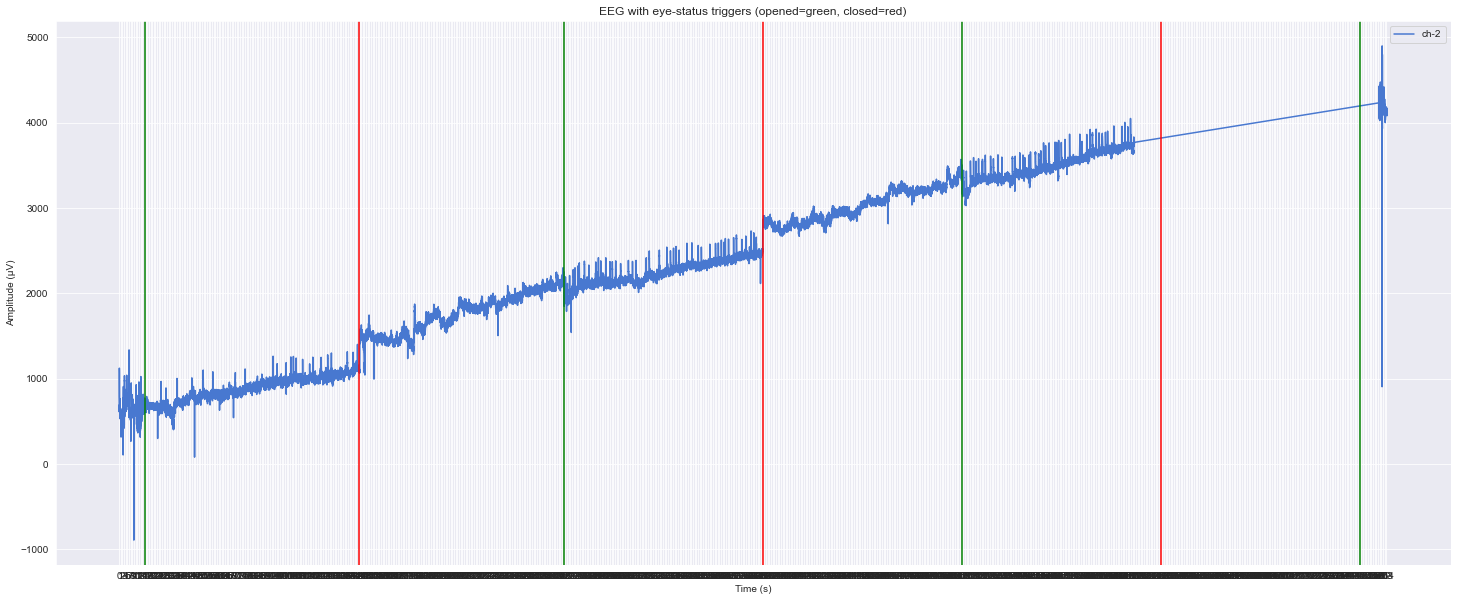

In [5]:
# prepare dict for the eeg channels
eeg = {f"ch-{ch + 1}": [] for ch in range(int(data[1]["info"]["channel_count"][0]))}

# each EEG channel as a list
for sample in data[1]["time_series"]:
    for ch, value in enumerate(sample):
        eeg[f"ch-{ch + 1}"].append(value)

# prepare list for the eyes state triggers
triggers = []
# on index 0 we have the python-generated UNIX epoch
# on index 1 we have 0.0 for closed and 1.0 for opened
triggers = [sample[1] for sample in data[0]["time_series"]]
#print(triggers)
# PLOT
%matplotlib inline
sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(25, 10))
plt.title("EEG with eye-status triggers (opened=green, closed=red)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")

# each EEG channel values as a line
for i, ch in enumerate(eeg):
    if i == 1:  # all channels of this recording (24)
        #sns.lineplot(x=eeg_time, y=eeg[ch], color=next(palette), label=ch)
        sns.lineplot(x=eeg_time[0:-1], y=eeg[ch][0:-1], color=next(palette), label=ch)

colors = ["red", "green"]
# each trigger as a vertical line
for i, trigger in enumerate(triggers_time):
    label = "eyes-closed" if triggers[i] == 0.0 else "eyes-open"
    color = colors[0] if triggers[i] == 0.0 else colors[1]
    plt.axvline(trigger, label=label, color=color)

plt.xticks(np.arange(0, eeg_time[-1], 1))
plt.savefig("recording_visualization.png")
plt.show()

# for i, ch in enumerate(eeg):
#     if i == 1:
#         plt.figure(figsize=(25,10))
#         #plt.subplot(24,1,i+1)
#         plt.title(i)
#         powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(eeg[ch][15883:144924], Fs=250)
#         plt.xlabel('Time')
#         #plt.xticks(eeg_time[1000:100000])
#         plt.ylabel('Frequency')
#         #plt.show()

#colors = ["red", "green"]
# each trigger as a vertical line
#for i, trigger in enumerate(triggers_time):
 #   label = "eyes-closed" if triggers[i] == 0.0 else "eyes-open"
  #  color = colors[0] if triggers[i] == 0.0 else colors[1]
   # plt.axvline(trigger, label=label, color=color)

#plt.xticks(np.arange(0, eeg_time[-1], 1))
#plt.savefig("recording_visualization.png")
#plt.show()

    
# plt.subplot(2, 12, 1)
# plt.specgram


# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
# #xfmt = md.DateFormatter('%M:%S')
# #ax1.xaxis.set_major_formatter(xfmt)
# #ax1.xaxis_date()
# ax1.plot(eeg_time, [eeg[ch] for i, ch in enumerate(eeg)]); ax1.set_title('Raw EEG')
# ax2.specgram(eeg, Fs=25); ax2.set_title('Spectrogram'); ax2.set_ylabel('Freq (Hz)');
# ax2.set_xlabel('Time (s)');

### MNE

#### Caution!
To make the following plots interactive, use %matplotlib notebook. Because jupyter notebook has problems switching between inline and notebook, you have to restart the kernel and run all the cells up to the cell where the timestamps are corrected (inclusively). Then run the follwoing cell.

trigger times (in sec): [ 15.883708 144.92416  268.5637   388.31824  508.39905  628.1523
 748.3456  ]
triggers (1: eyes open, 0: eyes closed): [1. 0. 1. 0. 1. 0. 1.]
Creating RawArray with float64 data, n_channels=2, n_times=7
    Range : 0 ... 6 =      0.000 ...     0.024 secs
Ready.
Creating RawArray with float64 data, n_channels=24, n_times=308108
    Range : 0 ... 308107 =      0.000 ...  1232.428 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00

C:\Users\lkrieger\anaconda3\envs\SeizureDetection\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


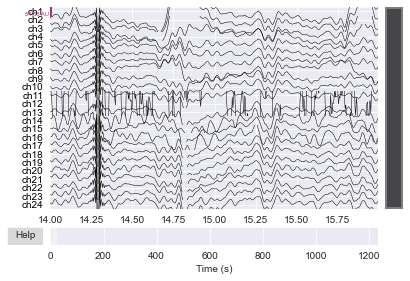

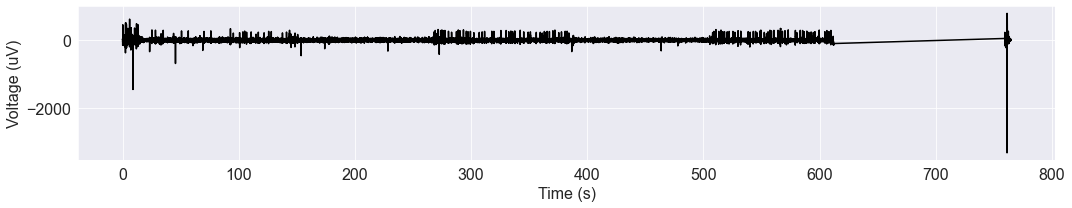

In [12]:
# get data: data1 for keypress data and data2 for EEG data
# corrected time for keypress data (data1)
data1 = data[0]["time_series"].T
data1[0] = triggers_time.T
print("trigger times (in sec):", data1[0])
print("triggers (1: eyes open, 0: eyes closed):", data1[1])

#data2 = data[1]["time_series"].T
data2 = data[1]["time_series"].T
assert data2.shape[0] == 24 # 24 EEG channels


# preperation of the data of keypresses
info1 = mne.create_info(['time', 'event'], 250)
raw1 = mne.io.RawArray(data1, info1)


# preperation of the EEG data
sfreq = float(250)
info2 = mne.create_info(['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8', 'ch9', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch16', 'ch17', 'ch18', 'ch19', 'ch20', 'ch21', 'ch22', 'ch23', 'ch24'], sfreq)
raw2 = mne.io.RawArray(data2, info2)

# low-pass and high-pass filtering in one step: band-pass filtering
# --> low pass to remove power-line noise
# --> high pass to remove drift
raw2.filter(1, 80., picks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,21,22,23], fir_design='firwin')


#%matplotlib notebook
%matplotlib inline
# plot a set of channels (or just a single channel) and look at a specific duration in seconds as from a starting time (in sec)
# starting time can be set interactively in the diagram
raw2.plot(duration=2, start=14, n_channels=24, scalings=dict(eeg=20e-6))

# look at an example channel
sig = raw2.get_data(mne.pick_channels(raw2.ch_names, ['ch1']), return_times=False)
sig = np.squeeze(sig)
plot_time_series(eeg_time[0:-1], sig[0:-1])




# aim: spectrogram
# Problem: events is used to look for a specific event in the EEG data e.g. specific spiking
# events = mne.find_events(raw1, stim_channel='event')

# Problem: wants to find the events in the EEG data for a given epoch
#epochs = mne.Epochs(raw2, events, tmin=0, tmax=10, baseline=(0, 0))


# define frequencies of interest 
#freqs = np.logspace(*np.log10([0, 40]))
#n_cycles = freqs / 2
#power, itc = tfr_morlet(raw2, freqs=freqs, n_cycles=n_cycles, picks=sig, use_fft=True, return_itc=True, decim=3, n_jobs=1)

# spectrogram
# power.plot(['ch1'], baseline=(0, 0), mode='logratio', title=power.ch_names['ch1'])


### Analysis of bursting behaviour


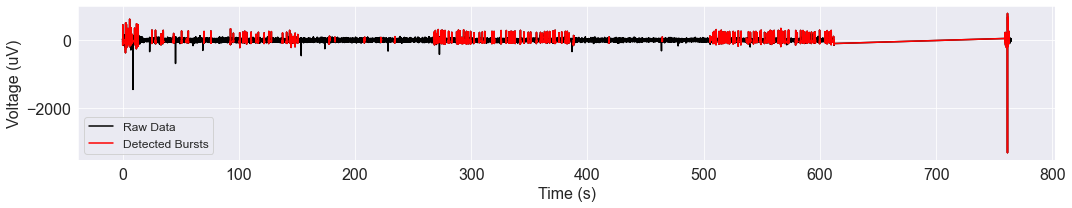

In [7]:
%matplotlib inline
# low and high threshold values for burst detection
amp_dual_thresh = (1, 2)

# Detect bursts of high amplitude oscillations in the extracted signal
bursting = detect_bursts_dual_threshold(sig[0:-1], 250, amp_dual_thresh, f_range=None, min_burst_duration=0.5)

# Plot original signal and burst activity
plot_bursts(eeg_time[0:-1], sig[0:-1], bursting, labels=['Raw Data', 'Detected Bursts'])

### Power spectral density analysis

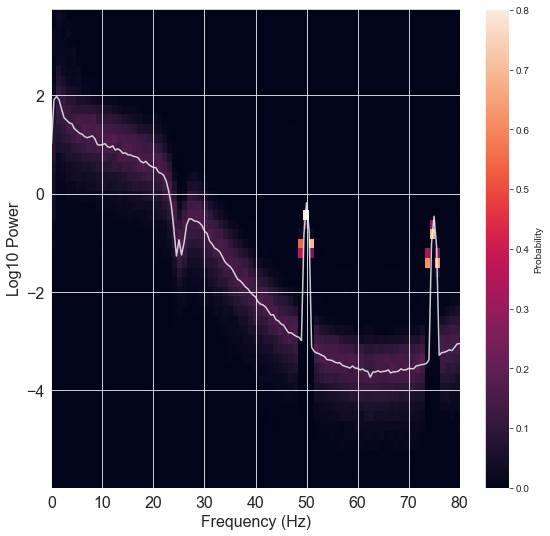

In [8]:
# Calculate the spectral histogram
# --> high density of low frequencies
# --> artifacts at around 50Hz and 75Hz

freqs, bins, spect_hist = compute_spectral_hist(sig, 250, nbins=50, f_range=(0, 80),
                                                cut_pct=(0.1, 99.9))
# Calculate a power spectrum, with median Welch
freq_med, psd_med = compute_spectrum(sig, 250, method='welch',
                                     avg_type='median', nperseg=250*2)
# Plot the spectral histogram
plot_spectral_hist(freqs, bins, spect_hist, freq_med, psd_med)


In [25]:
# # Calculate spectral coefficient of variation (SCV)
# freqs, scv = compute_scv(sig, 250, nperseg=int(250), noverlap=0)
# # Plot the SCV
# plot_scv(freqs, scv)


# # resampled SCV as a matrix
# # used a sliding window to filter out noise
# # SCV: spectral coefficient of variation as normalized esstimate of variance
# freqs, t_inds, scv_rs = compute_scv_rs(sig, 250)
# plot_scv_rs_lines(freqs, scv_rs)

# plot_scv_rs_matrix(freqs, eeg_time, scv_rs)

In [26]:
#powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(eeg[ch][15883:144924], Fs=250)
#spectrum, freq, t, im = plt.specgram(sig, 250,xextent=(0,750))

### References

https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html

https://neurodsp-tools.github.io/neurodsp/auto_examples/plot_mne_example.html

https://mne.tools/0.15/auto_tutorials/plot_artifacts_correction_filtering.html

https://neurodsp-tools.github.io/neurodsp/auto_tutorials/spectral/plot_SpectralVariance.html#sphx-glr-auto-tutorials-spectral-plot-spectralvariance-py